In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(ggplot2)
library(dplyr)
library(caret)
library(corrplot)
library(pROC)
library(randomForest)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data <- read.csv("../input/heart-disease-prediction-uci/heart.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


corrplot 0.88 loaded

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margi

In [2]:
head(data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
6,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


In [3]:
str(data)

'data.frame':	303 obs. of  14 variables:
 $ age     : int  63 37 41 56 57 57 56 44 52 57 ...
 $ sex     : int  1 1 0 1 0 1 0 1 1 1 ...
 $ cp      : int  3 2 1 1 0 0 1 1 2 2 ...
 $ trestbps: int  145 130 130 120 120 140 140 120 172 150 ...
 $ chol    : int  233 250 204 236 354 192 294 263 199 168 ...
 $ fbs     : int  1 0 0 0 0 0 0 0 1 0 ...
 $ restecg : int  0 1 0 1 1 1 0 1 1 1 ...
 $ thalach : int  150 187 172 178 163 148 153 173 162 174 ...
 $ exang   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ oldpeak : num  2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...
 $ slope   : int  0 0 2 2 2 1 1 2 2 2 ...
 $ ca      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ thal    : int  1 2 2 2 2 1 2 3 3 2 ...
 $ target  : int  1 1 1 1 1 1 1 1 1 1 ...


# Data Transformation

In [4]:
Heart_df <- data %>% 
        mutate(sex = if_else(sex == 1,"MALE","FEMALE"),
              fbs = if_else (fbs ==1 ,">120", "<=120"),
              exang = if_else (exang ==1 ,"YES", "NO"),
               cp = if_else (cp == 1, "ATYPICAL ANGINA",
                            if_else(cp == 2, "NON-ANGINAL PAIN","ASYMPTOMATIC")),
               restecg = if_else(restecg == 0, "NORMAL",
                                if_else(restecg == 1, "ABNORMALITY", "PROBABLE OR DEFINITE")),
               slope = as.factor(slope),
               ca = as.factor(ca),
               thal = as.factor(thal),
               target = if_else(target ==1 ,"YES","NO")) %>%
    mutate_if(is.character, as.factor)%>%
    dplyr::select(target,sex,fbs,exang,cp,restecg,slope,ca,thal,everything())

In [5]:
str(Heart_df)

'data.frame':	303 obs. of  14 variables:
 $ target  : Factor w/ 2 levels "NO","YES": 2 2 2 2 2 2 2 2 2 2 ...
 $ sex     : Factor w/ 2 levels "FEMALE","MALE": 2 2 1 2 1 2 1 2 2 2 ...
 $ fbs     : Factor w/ 2 levels "<=120",">120": 2 1 1 1 1 1 1 1 2 1 ...
 $ exang   : Factor w/ 2 levels "NO","YES": 1 1 1 1 2 1 1 1 1 1 ...
 $ cp      : Factor w/ 3 levels "ASYMPTOMATIC",..: 1 3 2 2 1 1 2 2 3 3 ...
 $ restecg : Factor w/ 3 levels "ABNORMALITY",..: 2 1 2 1 1 1 2 1 1 1 ...
 $ slope   : Factor w/ 3 levels "0","1","2": 1 1 3 3 3 2 2 3 3 3 ...
 $ ca      : Factor w/ 5 levels "0","1","2","3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ thal    : Factor w/ 4 levels "0","1","2","3": 2 3 3 3 3 2 3 4 4 3 ...
 $ age     : int  63 37 41 56 57 57 56 44 52 57 ...
 $ trestbps: int  145 130 130 120 120 140 140 120 172 150 ...
 $ chol    : int  233 250 204 236 354 192 294 263 199 168 ...
 $ thalach : int  150 187 172 178 163 148 153 173 162 174 ...
 $ oldpeak : num  2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...


# Data Visualization

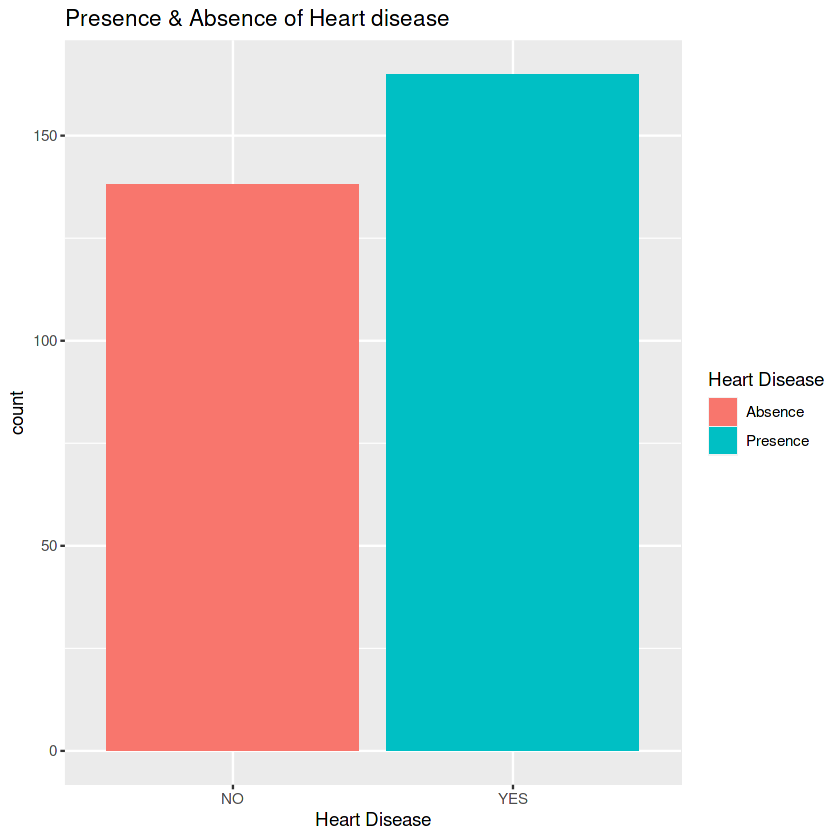

In [7]:
ggplot(Heart_df, aes(x=target, fill=target)) + 
    geom_bar()+
    xlab("Heart Disease")+
    ylab("count")+
    ggtitle("Presence & Absence of Heart disease")+
    scale_fill_discrete(name= 'Heart Disease', labels =c("Absence", "Presence"))
   

In [10]:
prop.table(table(Heart_df$target))


       NO       YES 
0.4554455 0.5445545 

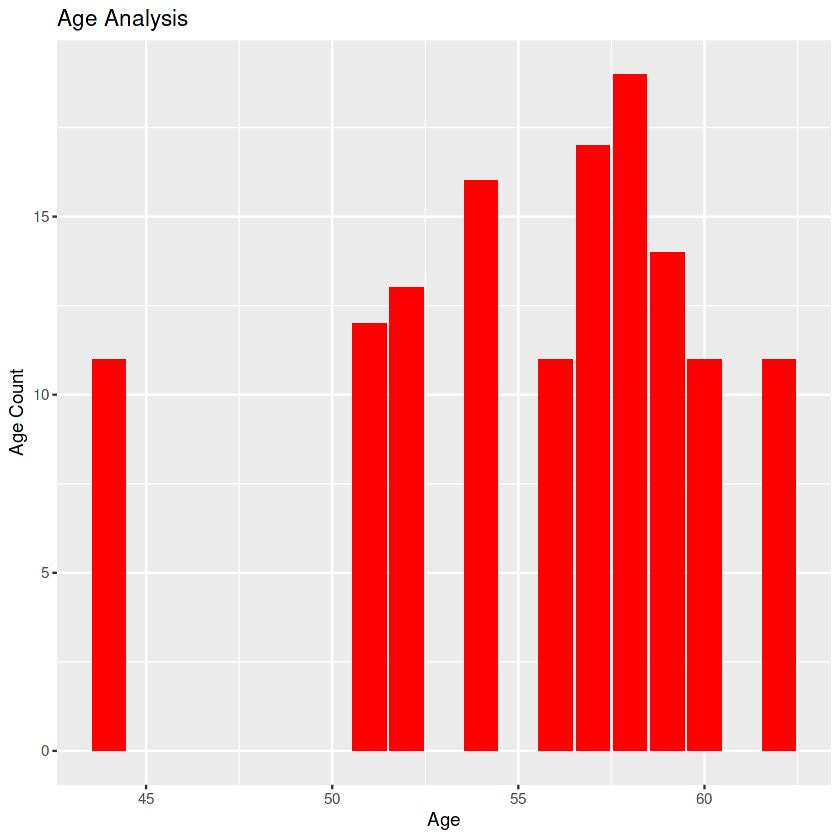

In [11]:
Heart_df %>% 
    group_by(age) %>%
    count() %>%
    filter(n>10) %>%
    ggplot() +
    geom_col(aes(age,n),fill = 'red')+
    ggtitle("Age Analysis")+
    xlab("Age")+
    ylab("Age Count")



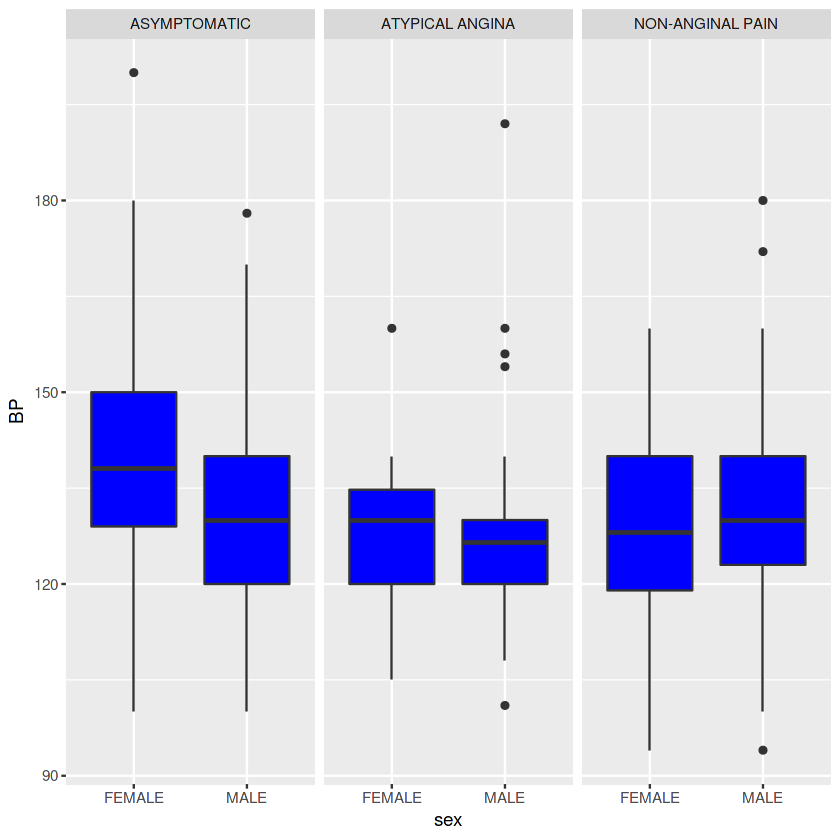

In [18]:
Heart_df %>%
    ggplot(aes(x=sex, y=trestbps))+
    geom_boxplot(fill= 'blue')+
    xlab("sex")+
    ylab("BP")+
    facet_grid(~cp)
    

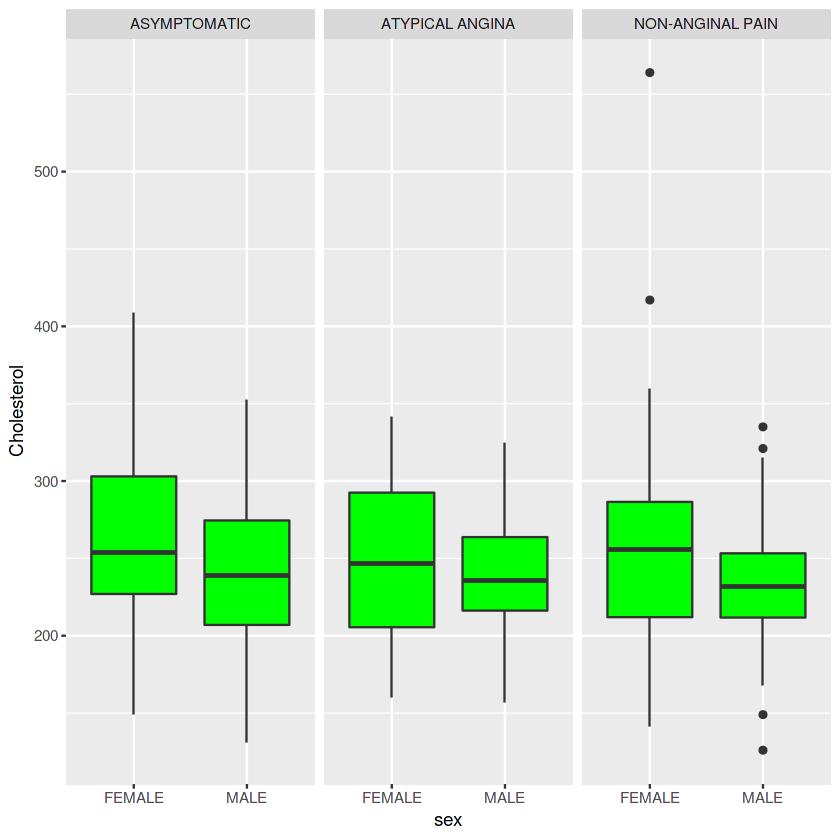

In [19]:
Heart_df %>%
    ggplot(aes(x=sex, y=chol))+
    geom_boxplot(fill= 'green')+
    xlab("sex")+
    ylab("Cholesterol")+
    facet_grid(~cp)

,age,trestbps,chol,thalach,oldpeak
age,1.0000000,0.27935091,0.213677957,-0.398521938,0.21001257
trestbps,0.2793509,1.00000000,0.123174207,-0.046697728,0.19321647
chol,0.2136780,0.12317421,1.000000000,-0.009939839,0.05395192
thalach,-0.3985219,-0.04669773,-0.009939839,1.000000000,-0.34418695
oldpeak,0.2100126,0.19321647,0.053951920,-0.344186948,1.00000000


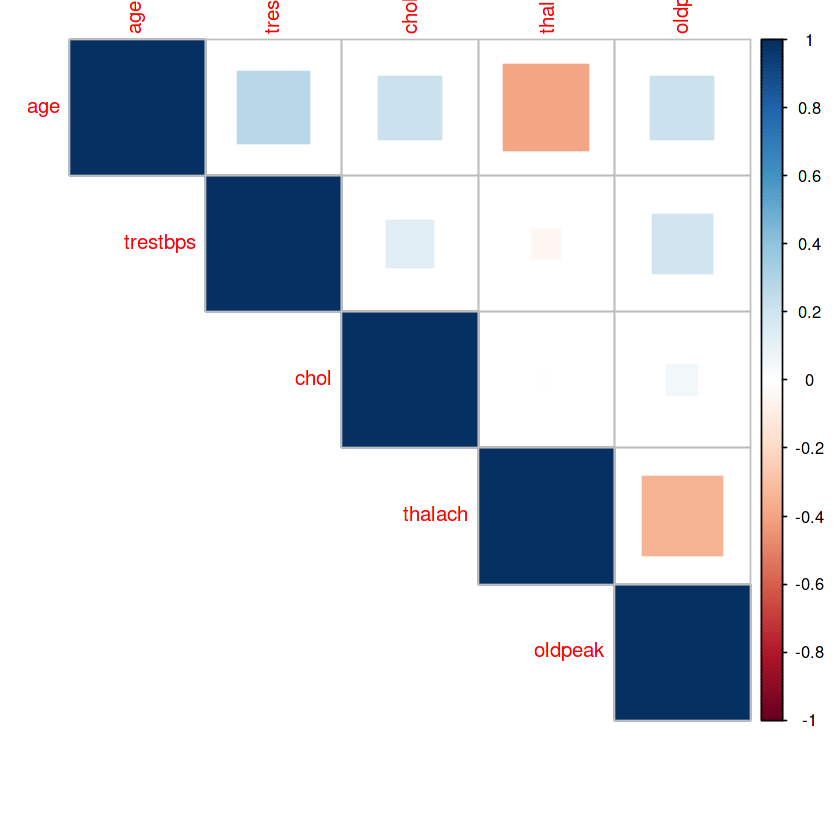

In [21]:
cor_heart <- cor(Heart_df[,10:14])
cor_heart

corrplot(cor_heart, method ='square', type= 'upper')

# Checking for null values

In [22]:
any(is.na(Heart_df))


[1] FALSE

# Traning and Testing the data

In [23]:
set.seed(10)

### Splitting Data


In [24]:
TraindataRows <- createDataPartition(Heart_df$target, p=0.7, list= FALSE)
trainData <- Heart_df[TraindataRows,]
testData <- Heart_df[-TraindataRows,]


Creating 2 Lists

In [25]:
AUC = list()
Accuracy = list()

# Logistic Regression

In [26]:
logRegModel <- train(target ~ ., data=trainData, method = 'glm', family = 'binomial')
logRegPrediction <- predict(logRegModel, testData)
logRegPredictionprob <- predict(logRegModel, testData, type='prob')[2]
logRegConfMat <- confusionMatrix(logRegPrediction, testData[,"target"])

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


In [27]:
AUC$logReg <- roc(as.numeric(testData$target),as.numeric(as.matrix((logRegPredictionprob))))$auc
Accuracy$logReg <- logRegConfMat$overall['Accuracy']  

Setting levels: control = 1, case = 2

Setting direction: controls < cases



# Support Vector Machine

In [28]:
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 5,
                           ## Estimate class probabilities
                           classProbs = TRUE,
                           ## Evaluate performance using 
                           ## the following function
                           summaryFunction = twoClassSummary)

In [29]:
svmModel <- train(target ~ ., data = trainData,
                  method = "svmRadial", 
                  trControl = fitControl ,
                  preProcess = c("center", "scale"),
                  tunelength = 8,
                  metric = "ROC")
svmPrediction <- predict(svmModel, testData)
svmPredictionprob <- predict(svmModel, testData, type='prob')[2]
svmConfMat <- confusionMatrix(svmPrediction, testData[,"target"])

In [30]:
AUC$svm <- roc(as.numeric(testData$target),as.numeric(as.matrix((svmPredictionprob))))$auc
Accuracy$svm <- svmConfMat$overall['Accuracy'] 

Setting levels: control = 1, case = 2

Setting direction: controls < cases



# Random Forest

In [31]:
RFModel <- randomForest(target ~ .,
                    data=trainData, 
                    importance=TRUE, 
                    ntree=200)
#varImpPlot(RFModel)
RFPrediction <- predict(RFModel, testData)
RFPredictionprob = predict(RFModel,testData,type="prob")[, 2]

RFConfMat <- confusionMatrix(RFPrediction, testData[,"target"])


In [32]:
AUC$RF <- roc(as.numeric(testData$target),as.numeric(as.matrix((RFPredictionprob))))$auc
Accuracy$RF <- RFConfMat$overall['Accuracy']

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [33]:
row.names <- names(Accuracy)
col.names <- c("AUC", "Accuracy")
cbind(as.data.frame(matrix(c(AUC,Accuracy),nrow = 3, ncol = 2,
                           dimnames = list(row.names, col.names))))

,AUC,Accuracy
,<named list>,<named list>
logReg,0.9298158,0.8666667
svm,0.8959681,0.8111111
RF,0.8800398,0.8


In [34]:
summary(logRegModel)$coeff


,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-1.002901016,3.672817206,-0.2730604,0.784806770
sexMALE,-1.108411204,0.629831168,-1.7598545,0.078432483
`fbs>120`,0.099727473,0.695895093,0.1433082,0.886046780
exangYES,-1.053668716,0.507650309,-2.0755798,0.037932833
`cpATYPICAL ANGINA`,0.576785085,0.673929885,0.8558533,0.392078955
`cpNON-ANGINAL PAIN`,1.766764364,0.599090285,2.9490786,0.003187229
restecgNORMAL,-0.389889283,0.467477322,-0.8340282,0.404265076
`restecgPROBABLE OR DEFINITE`,-1.405550323,2.763325521,-0.5086445,0.611001432
slope1,-0.176704487,0.989144482,-0.1786438,0.858217433
slope2,0.553034654,1.061991982,0.5207522,0.602539410


In [35]:
logRegConfMat

Confusion Matrix and Statistics

          Reference
Prediction NO YES
       NO  34   5
       YES  7  44
                                          
               Accuracy : 0.8667          
                 95% CI : (0.7787, 0.9292)
    No Information Rate : 0.5444          
    P-Value [Acc > NIR] : 6.754e-11       
                                          
                  Kappa : 0.7301          
                                          
 Mcnemar's Test P-Value : 0.7728          
                                          
            Sensitivity : 0.8293          
            Specificity : 0.8980          
         Pos Pred Value : 0.8718          
         Neg Pred Value : 0.8627          
             Prevalence : 0.4556          
         Detection Rate : 0.3778          
   Detection Prevalence : 0.4333          
      Balanced Accuracy : 0.8636          
                                          
       'Positive' Class : NO              
                                 

In [36]:
RFConfMat

Confusion Matrix and Statistics

          Reference
Prediction NO YES
       NO  29   6
       YES 12  43
                                          
               Accuracy : 0.8             
                 95% CI : (0.7025, 0.8769)
    No Information Rate : 0.5444          
    P-Value [Acc > NIR] : 3.697e-07       
                                          
                  Kappa : 0.5919          
                                          
 Mcnemar's Test P-Value : 0.2386          
                                          
            Sensitivity : 0.7073          
            Specificity : 0.8776          
         Pos Pred Value : 0.8286          
         Neg Pred Value : 0.7818          
             Prevalence : 0.4556          
         Detection Rate : 0.3222          
   Detection Prevalence : 0.3889          
      Balanced Accuracy : 0.7924          
                                          
       'Positive' Class : NO              
                                 

In [37]:
svmConfMat

Confusion Matrix and Statistics

          Reference
Prediction NO YES
       NO  34  10
       YES  7  39
                                          
               Accuracy : 0.8111          
                 95% CI : (0.7149, 0.8859)
    No Information Rate : 0.5444          
    P-Value [Acc > NIR] : 1.061e-07       
                                          
                  Kappa : 0.6215          
                                          
 Mcnemar's Test P-Value : 0.6276          
                                          
            Sensitivity : 0.8293          
            Specificity : 0.7959          
         Pos Pred Value : 0.7727          
         Neg Pred Value : 0.8478          
             Prevalence : 0.4556          
         Detection Rate : 0.3778          
   Detection Prevalence : 0.4889          
      Balanced Accuracy : 0.8126          
                                          
       'Positive' Class : NO              
                                 